In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
data = pd.read_csv('/content/AEP_hourly.csv')

In [8]:
data.head()

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0


In [9]:
data.shape

(121273, 2)

In [10]:
data.describe()

,AEP_MW
count,121273.000000
mean,15499.513717
std,2591.399065
min,9581.000000
25%,13630.000000
50%,15310.000000
75%,17200.000000
max,25695.000000


In [11]:
#What we need to do?
#Basically predict how much energy will be consumed in the future

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121273 entries, 0 to 121272
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  121273 non-null  object 
 1   AEP_MW    121273 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.9+ MB


#EDA and Preprocessing

In [13]:
data['Datetime'] = pd.to_datetime(data['Datetime'])
data = data.set_index('Datetime')

In [14]:
data.head()

,AEP_MW
Datetime,
2004-12-31 01:00:00,13478.0
2004-12-31 02:00:00,12865.0
2004-12-31 03:00:00,12577.0
2004-12-31 04:00:00,12517.0
2004-12-31 05:00:00,12670.0


Checking if there are any misising values:

In [15]:
data.isnull().sum()

,0
AEP_MW,0


Getting the range of values of time data

In [16]:
print(data.index.min(), "->" ,data.index.max())

2004-10-01 01:00:00 -> 2018-08-03 00:00:00


Visualizing our data for better insights

Energy consumption over time:

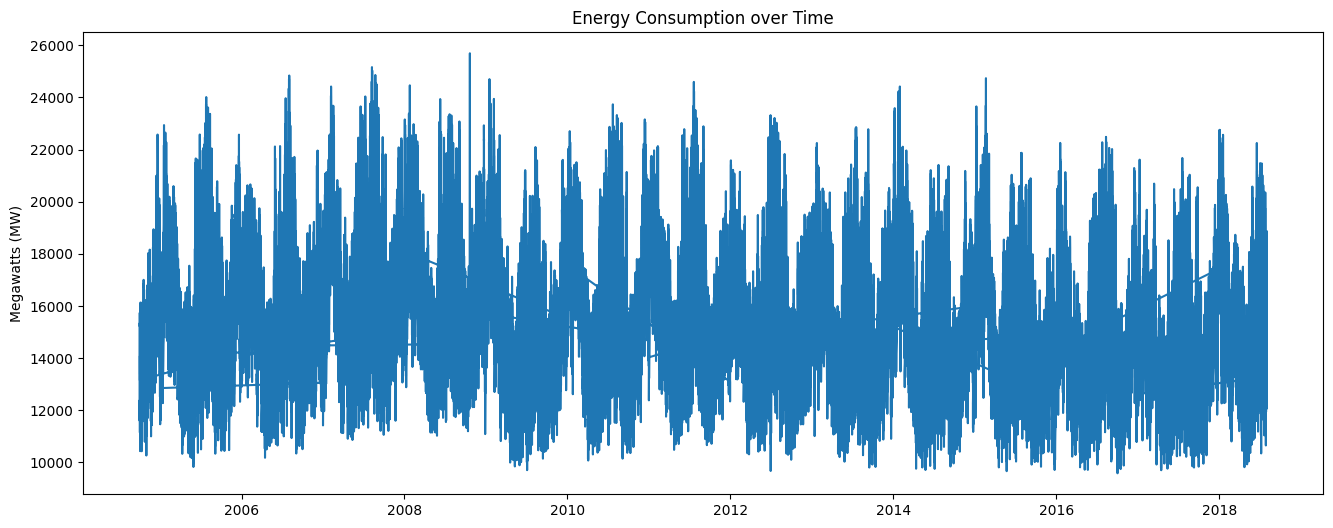

In [17]:
plt.figure(figsize= (16,6))
plt.plot(data['AEP_MW'])
plt.title("Energy Consumption over Time")
plt.ylabel("Megawatts (MW)")
plt.show()

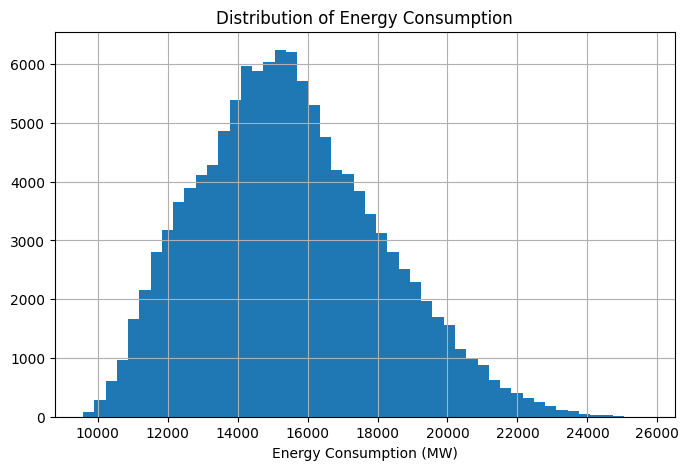

In [18]:
data['AEP_MW'].hist(bins=50, figsize=(8,5))
plt.xlabel("Energy Consumption (MW)")
plt.title("Distribution of Energy Consumption")
plt.show()

Most values lie around ~15000 MW

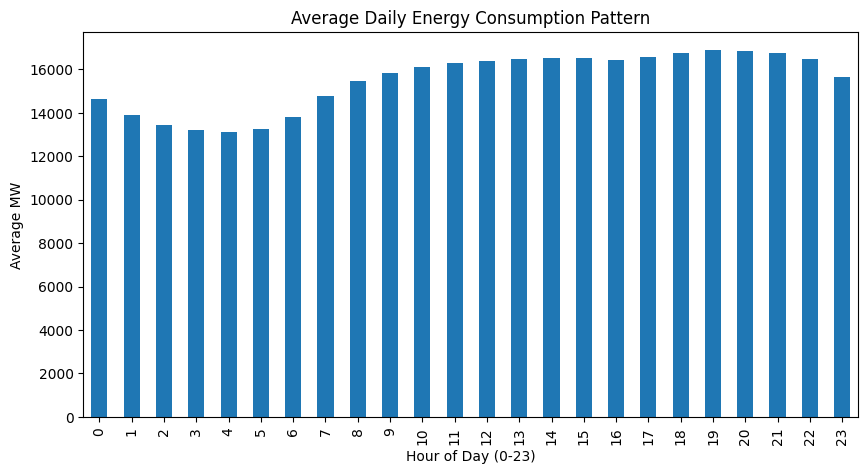

In [19]:
daily_pattern = data.groupby(data.index.hour)['AEP_MW'].mean()

plt.figure(figsize=(10,5))
daily_pattern.plot(kind='bar')
plt.title("Average Daily Energy Consumption Pattern")
plt.xlabel("Hour of Day (0-23)")
plt.ylabel("Average MW")
plt.show()


#Feature Engineering

We now need to convert Datetime into numeric features

Start by extracting all the time based features:

In [20]:
data['hour'] = data.index.hour
data['dayofweek'] = data.index.dayofweek
data['month'] = data.index.month
data['year'] = data.index.year


In [21]:
data.head(10)

,AEP_MW,hour,dayofweek,month,year
Datetime,,,,,
2004-12-31 01:00:00,13478.0,1,4,12,2004
2004-12-31 02:00:00,12865.0,2,4,12,2004
2004-12-31 03:00:00,12577.0,3,4,12,2004
2004-12-31 04:00:00,12517.0,4,4,12,2004
2004-12-31 05:00:00,12670.0,5,4,12,2004
2004-12-31 06:00:00,13038.0,6,4,12,2004
2004-12-31 07:00:00,13692.0,7,4,12,2004
2004-12-31 08:00:00,14297.0,8,4,12,2004
2004-12-31 09:00:00,14719.0,9,4,12,2004


Generating Lag features:

These features depend on the past hour/day/week which helps us to predict the future values

lag1 = “previous hour’s consumption” <br/>
lag24 = “same hour yesterday” <br/>
lag168 = “same hour last week”

In [22]:
data['lag1'] = data['AEP_MW'].shift(1)
data['lag24'] = data['AEP_MW'].shift(24)
data['lag168'] = data['AEP_MW'].shift(168)

In [23]:
data.head()

,AEP_MW,hour,dayofweek,month,year,lag1,lag24,lag168
Datetime,,,,,,,,
2004-12-31 01:00:00,13478.0,1,4,12,2004,NaN,NaN,NaN
2004-12-31 02:00:00,12865.0,2,4,12,2004,13478.0,NaN,NaN
2004-12-31 03:00:00,12577.0,3,4,12,2004,12865.0,NaN,NaN
2004-12-31 04:00:00,12517.0,4,4,12,2004,12577.0,NaN,NaN
2004-12-31 05:00:00,12670.0,5,4,12,2004,12517.0,NaN,NaN


Generating Rolling Features:

rolling_mean_24 = average of last 24 hours <br/>
rolling_std_24 = standard deviation of last 24 hours <br/>
rolling_mean_168 = average of last 7 days (7 × 24 = 168 hours) <br/>

In [24]:
data['rolling_mean_24'] = data['AEP_MW'].rolling(24).mean()
data['rolling_std_24'] = data['AEP_MW'].rolling(24).std()

data['rolling_mean_168'] = data['AEP_MW'].rolling(168).mean()

In [25]:
data.head()

,AEP_MW,hour,dayofweek,month,year,lag1,lag24,lag168,rolling_mean_24,rolling_std_24,rolling_mean_168
Datetime,,,,,,,,,,,
2004-12-31 01:00:00,13478.0,1,4,12,2004,NaN,NaN,NaN,NaN,NaN,NaN
2004-12-31 02:00:00,12865.0,2,4,12,2004,13478.0,NaN,NaN,NaN,NaN,NaN
2004-12-31 03:00:00,12577.0,3,4,12,2004,12865.0,NaN,NaN,NaN,NaN,NaN
2004-12-31 04:00:00,12517.0,4,4,12,2004,12577.0,NaN,NaN,NaN,NaN,NaN
2004-12-31 05:00:00,12670.0,5,4,12,2004,12517.0,NaN,NaN,NaN,NaN,NaN


In [26]:
data = data.dropna()

In [27]:
data.head()

,AEP_MW,hour,dayofweek,month,year,lag1,lag24,lag168,rolling_mean_24,rolling_std_24,rolling_mean_168
Datetime,,,,,,,,,,,
2004-12-24 01:00:00,15645.0,1,4,12,2004,15676.0,16669.0,13478.0,16270.625000,955.338675,16351.315476
2004-12-24 02:00:00,15265.0,2,4,12,2004,15645.0,16218.0,12865.0,16230.916667,977.177075,16365.601190
2004-12-24 03:00:00,15138.0,3,4,12,2004,15265.0,16135.0,12577.0,16189.375000,1002.301170,16380.845238
2004-12-24 04:00:00,15068.0,4,4,12,2004,15138.0,16107.0,12517.0,16146.083333,1028.119682,16396.029762
2004-12-24 05:00:00,15122.0,5,4,12,2004,15068.0,16229.0,12670.0,16099.958333,1048.860727,16410.625000


In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 121105 entries, 2004-12-24 01:00:00 to 2018-01-02 00:00:00
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   AEP_MW            121105 non-null  float64
 1   hour              121105 non-null  int32  
 2   dayofweek         121105 non-null  int32  
 3   month             121105 non-null  int32  
 4   year              121105 non-null  int32  
 5   lag1              121105 non-null  float64
 6   lag24             121105 non-null  float64
 7   lag168            121105 non-null  float64
 8   rolling_mean_24   121105 non-null  float64
 9   rolling_std_24    121105 non-null  float64
 10  rolling_mean_168  121105 non-null  float64
dtypes: float64(7), int32(4)
memory usage: 9.2 MB


#Outlier Detection

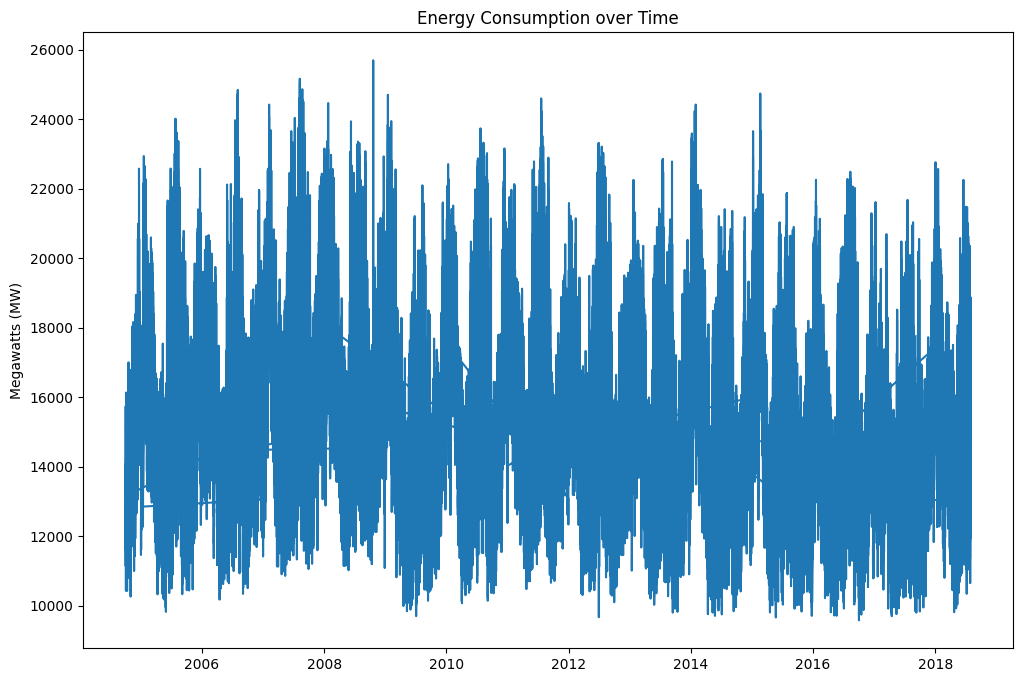

In [29]:
plt.figure(figsize=(12,8))
plt.plot(data['AEP_MW'])
plt.title("Energy Consumption over Time")
plt.ylabel("Megawatts (MW)")
plt.show()

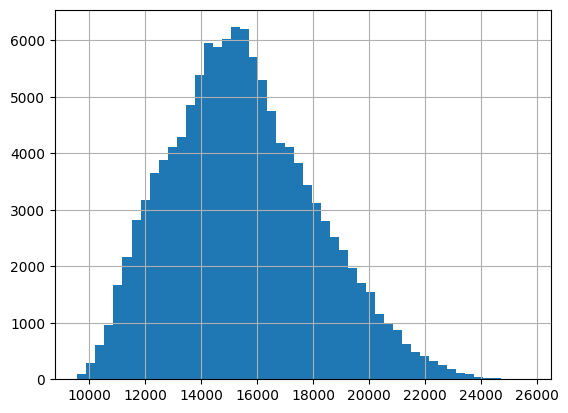

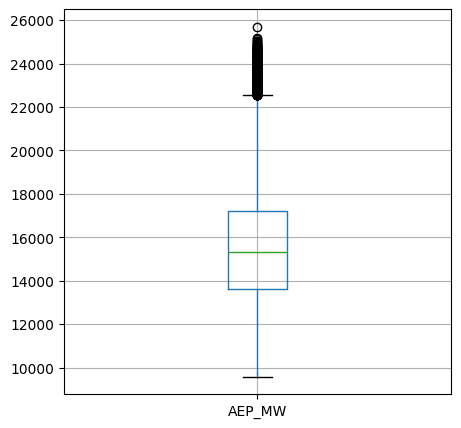

In [30]:
data['AEP_MW'].hist(bins=50)
plt.show()

print("\n")
data.boxplot(column='AEP_MW', figsize=(5,5))
plt.show()

There are outliers in the dataset but values like 23000-26000 MW may be possible in extreme cases like during summers

In [31]:
Q1 = data['AEP_MW'].quantile(0.25)
Q3 = data['AEP_MW'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print("Lower Bound: ", lower_bound)
print("Upper Bound: ", upper_bound)

outliers = data[(data['AEP_MW'] < lower_bound) | (data['AEP_MW'] > upper_bound)]
print("Number of Outliers: ", len(outliers))

Lower Bound:  8270.0
Upper Bound:  22558.0
Number of Outliers:  663


In [32]:
data.shape

(121105, 11)

We won't be removing outliers here as extreme values in this case may be possible

#Train - Test Split

In time-series data we split the data chronologically

We train the model on older data (past data)

And we test the model on most recent data in order to predict the future better

In [33]:
data = data.sort_values("Datetime")

split_ratio = 0.8
split_point = int(len(data) * split_ratio)

train = data.iloc[:split_point]
test = data.iloc[split_point:]

In [34]:
train.shape

(96884, 11)

In [35]:
test.shape

(24221, 11)

In [36]:
train.head()

,AEP_MW,hour,dayofweek,month,year,lag1,lag24,lag168,rolling_mean_24,rolling_std_24,rolling_mean_168
Datetime,,,,,,,,,,,
2004-10-01 01:00:00,12379.0,1,4,10,2004,12172.0,12260.0,12468.0,12964.208333,1065.175306,13884.958333
2004-10-01 02:00:00,11935.0,2,4,10,2004,12379.0,11672.0,12046.0,12975.166667,1052.581698,13884.297619
2004-10-01 03:00:00,11692.0,3,4,10,2004,11935.0,11352.0,11749.0,12989.333333,1031.869964,13883.958333
2004-10-01 04:00:00,11597.0,4,4,10,2004,11692.0,11177.0,11784.0,13006.833333,1002.953667,13882.845238
2004-10-01 05:00:00,11681.0,5,4,10,2004,11597.0,11142.0,11919.0,13029.291667,964.685012,13881.428571


In [37]:
target = 'AEP_MW'
feature_columns = ['hour', 'dayofweek', 'month',
                   'lag1', 'lag24', 'lag168',
                   'rolling_mean_24', 'rolling_std_24', 'rolling_mean_168']

X = data[feature_columns]
y = data[target]

In [38]:
X_train, X_test = X.iloc[:split_point], X.iloc[split_point:]
y_train, y_test = y.iloc[:split_point], y.iloc[split_point:]

In [39]:
X_train.shape

(96884, 9)

In [40]:
X_test.shape

(24221, 9)

In [41]:
y_train.shape

(96884,)

In [42]:
y_test.shape

(24221,)

#Linear Regression

In [43]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score

lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [44]:
y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)

In [45]:
y_pred_train

array([12169.20555298, 12181.11233159, 11771.03855   , ...,
       14128.24628739, 14202.46710672, 14118.3698406 ])

In [46]:
y_pred_test

array([14442.11662232, 14622.64362689, 14286.58240974, ...,
       16730.0272109 , 16411.19457028, 15519.17062933])

In [47]:
y_train[0]

/tmp/ipython-input-2332557866.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train[0]


np.float64(12379.0)

In [48]:
y_pred_train[0]

np.float64(12169.205552981888)

In [49]:
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

train_mae = mean_absolute_error(y_test, y_pred_test)
test_mae = mean_absolute_error(y_test, y_pred_test)

In [50]:
r2 = r2_score(y_test, y_pred_test)

In [51]:
print(train_rmse)

563.1949949501327


In [52]:
print(test_rmse)

532.4754853356965


In [53]:
print(train_mae)

396.5589712751394


In [54]:
print(test_mae)

396.5589712751394


In [55]:
print("R2 Score: ", r2)

R2 Score:  0.952595948511041


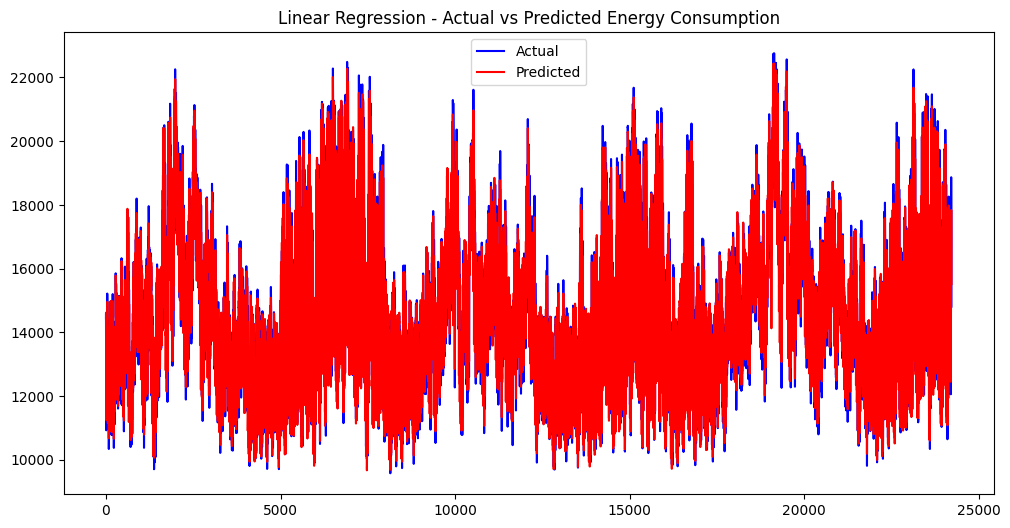

In [56]:
plt.figure(figsize=(12,6))
plt.plot(y_test.values, label="Actual", color='blue')
plt.plot(y_pred_test, label="Predicted", color='red')
plt.legend()
plt.title("Linear Regression - Actual vs Predicted Energy Consumption")
plt.show()

#XG Boost

In [57]:
from xgboost import XGBRegressor

In [58]:
xgb = XGBRegressor(
    n_estimators = 200,
    learning_rate = 0.1,
    max_depth = 6,
    random_state = 42
)
xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=None, num_parallel_tree=None, ...)

In [59]:
xgb_y_pred = xgb.predict(X_test)

mse = mean_squared_error(y_test, xgb_y_pred)
r2 = r2_score(y_test, xgb_y_pred)

In [60]:
print(mse)

66840.02731804733


In [61]:
print("r2 score: ", r2)

r2 score:  0.9888248633152199


The r2 score of XGBoost is better than the r2 score of Linear Regression

Visualizing the impact of each feature in XG Boost model

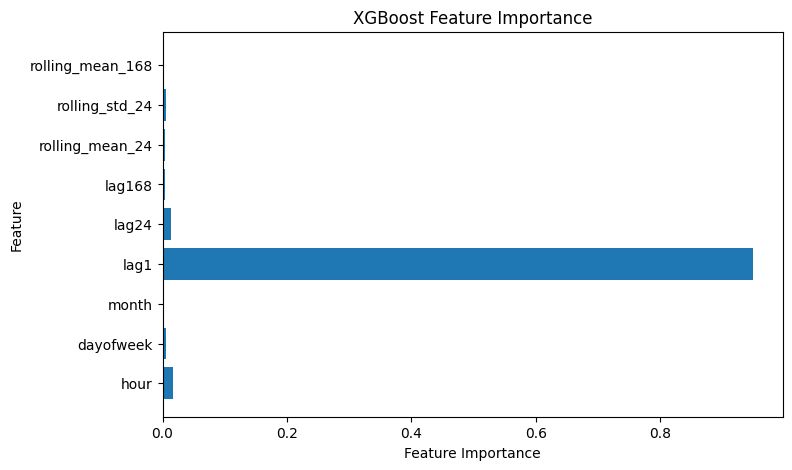

In [62]:
plt.figure(figsize=(8,5))
plt.barh(X.columns, xgb.feature_importances_)
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("XGBoost Feature Importance")
plt.show()

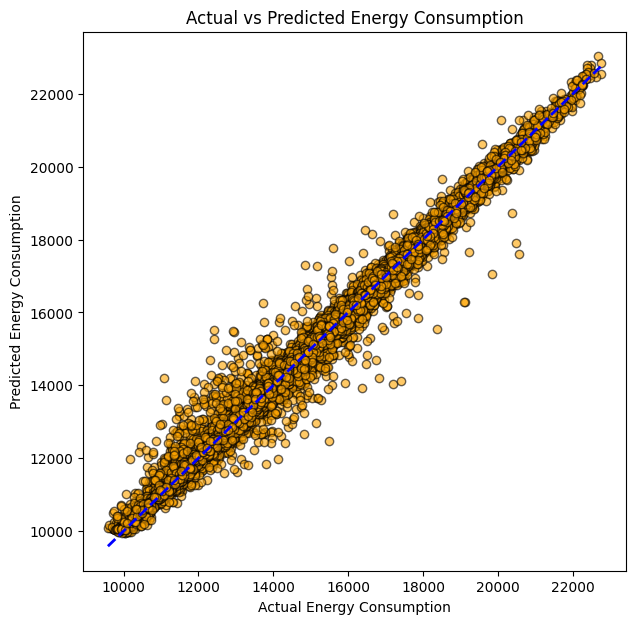

In [63]:
plt.figure(figsize=(7,7))
plt.scatter(y_test, xgb_y_pred, color='orange', alpha=0.6, edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='blue', lw=2, linestyle='--')
plt.xlabel("Actual Energy Consumption")
plt.ylabel("Predicted Energy Consumption")
plt.title("Actual vs Predicted Energy Consumption")
plt.show()

Here we can see that many points lie close to the blue line(actual predictions) which make up to good predictions

#Random Forest

In [64]:
from sklearn.ensemble import RandomForestRegressor

In [65]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [66]:
rf_y_pred = rf.predict(X_test)

In [67]:
rf_mse = mean_squared_error(y_test, rf_y_pred)
rf_r2 = r2_score(y_test, rf_y_pred)

In [68]:
rf_mse

74153.22399380703

In [69]:
rf_r2

0.9876021532755394

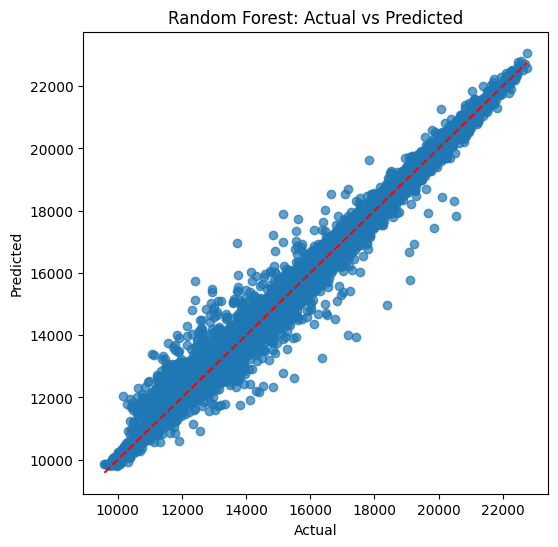

In [70]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, rf_y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Random Forest: Actual vs Predicted")
plt.show()

#Exporting models to joblib files

In [71]:
import joblib
import json
from google.colab import files

In [74]:
with open('LinearRegression.joblib', 'wb') as f:
    joblib.dump(lr, f)

with open('XGBoost.joblib', 'wb') as f:
    joblib.dump(xgb, f)

with open('RandomForest.joblib', 'wb') as f:
    joblib.dump(rf, f)

with open('feature_columns.json', 'w') as f:
    json.dump(feature_columns, f)

Downloading all these files to local system

In [75]:
files.download('LinearRegression.joblib')
files.download('XGBoost.joblib')
files.download('RandomForest.joblib')
files.download('feature_columns.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>